Mnist_data_set


Importing the libraries and setting manual seed using `set_seed`.

In [1]:
## standard libraries
import matplotlib.pyplot as plt
import numpy as np
import warnings
from IPython.display import clear_output

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## PyTorch Torchvision
import torchvision

warnings.filterwarnings('ignore')

In [2]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False
# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


For the Hyperbolic layers and functions, we're going to use geoopt library

In [3]:
!pip install -q git+https://github.com/geoopt/geoopt.git
! [ ! -f mobius_linear_example.py ] && wget -q https://raw.githubusercontent.com/geoopt/geoopt/master/examples/mobius_linear_example.py

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [4]:
import geoopt
from mobius_linear_example import MobiusLinear

Here, we define the paths which will be used in this notebook.

In [5]:
DATA_PATH = './data'

 setting up the MNIST` dataset. MNIST consists of 70000 tiny (28*28) gray scale images of handwritten digits, from zero to nine.

In [6]:
mean = (0.1307,)
std = (0.3081,)

transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=mean,std=std)
    ])

# Train dataset - downloading the training dataset. Training dataset is splitted into train and val parts.
main_trainset = torchvision.datasets.MNIST(root=DATA_PATH, train = True, download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(main_trainset, [10000, 50000], generator=torch.Generator().manual_seed(42))

# Test dataset - downloading and loading the testing dataset.
testset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)
testset_small, _ = torch.utils.data.random_split(main_trainset, [30000, 30000], generator=torch.Generator().manual_seed(42))

# Create dataloaders for the train, val and test sets
batch_size = 8
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset_small, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 157492106.57it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41007343.88it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 42524788.46it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 4372395.86it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



visualize some of the images from the dataset.

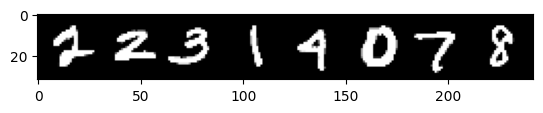

     2    2    3    1    4    0    7    8   


In [7]:
# Extract class names
classes = torchvision.datasets.MNIST.classes
# Class names are like 0 - zero
classes_num = [c.split('-')[0] for c in classes]

# Functions to show an image
def imshow(img):
    # What should I do here to unnormalize?
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)  # Corrected here

# Show images
imshow(torchvision.utils.make_grid(images))
print('     '+' '.join(f'{classes_num[labels[j]]:4s}' for j in range(batch_size)))


## Implementing Neural Networks

### Euclidean Neural Network
 Euclidean neural network. The neural network consists of six fully connected layers. To create the fully connected layers in Euclidean space, `nn.Linear` in used.

In [8]:
class EuclideanNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 750)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(750, 500)  # New layer
        self.relu2 = nn.ReLU()          # New activation function
        self.fc3 = nn.Linear(500, 250)  # New layer
        self.relu3 = nn.ReLU()          # New activation function
        self.fc4 = nn.Linear(250, 100)  # New layer
        self.relu4 = nn.ReLU()          # New activation function
        self.fc5 = nn.Linear(100, 20)   # New layer
        self.relu5 = nn.ReLU()          # New activation function
        self.fc6 = nn.Linear(20, 10)

    def forward(self, x):
        out_x = self.fc1(x)
        out_x = self.relu1(out_x)
        out_x = self.fc2(out_x)
        out_x = self.relu2(out_x)
        out_x = self.fc3(out_x)
        out_x = self.relu3(out_x)
        out_x = self.fc4(out_x)
        out_x = self.relu4(out_x)
        out_x = self.fc5(out_x)
        out_x = self.relu5(out_x)
        out_x = self.fc6(out_x)
        return out_x

# Create an instance of the EuclideanNet
euclidean_net = EuclideanNet().to(device)



In [9]:
# Count the number of trainable parameters
total_params = sum(p.numel() for p in euclidean_net.parameters() if p.requires_grad)
print("Total Trainable Parameters:", total_params)

Total Trainable Parameters: 1116830


In [10]:
pip install torchsummary


In [11]:
from torchsummary import summary

# Create an instance of the EuclideanNet
euclidean_net = EuclideanNet().to(device)

# Generate a summary of the model with correct input size
summary(euclidean_net, input_size=(batch_size, 28*28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 8, 750]         588,750
              ReLU-2               [-1, 8, 750]               0
            Linear-3               [-1, 8, 500]         375,500
              ReLU-4               [-1, 8, 500]               0
            Linear-5               [-1, 8, 250]         125,250
              ReLU-6               [-1, 8, 250]               0
            Linear-7               [-1, 8, 100]          25,100
              ReLU-8               [-1, 8, 100]               0
            Linear-9                [-1, 8, 20]           2,020
             ReLU-10                [-1, 8, 20]               0
           Linear-11                [-1, 8, 10]             210
Total params: 1,116,830
Trainable params: 1,116,830
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forw

### Hyperbolic

Next step is to create a neural network in hyperbolic space. This network consists of six fully connected layer, similar to the netowrk defined in the Euclidean space. To define a fully connected layer in the hyperbolic space, `MobiusLinear` is used.

In [12]:
def hyperbolic_ReLU(hyperbolic_input, manifold):
    euclidean_input = manifold.logmap0(hyperbolic_input)
    euclidean_output = F.relu(euclidean_input)
    hyperbolic_output = manifold.expmap0(euclidean_output)
    return hyperbolic_output

In [13]:
class HyperbolicNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = MobiusLinear(28 * 28, 750)
        self.fc2 = MobiusLinear(750, 500)  # New layer
        self.fc3 = MobiusLinear(500, 250)  # New layer
        self.fc4 = MobiusLinear(250, 100)  # New layer
        self.fc5 = MobiusLinear(100, 20)   # New layer
        self.fc6 = MobiusLinear(20, 10)

    def forward(self, x, manifold):
        out_x = self.fc1(x)
        out_x = hyperbolic_ReLU(out_x, manifold)
        out_x = self.fc2(out_x)
        out_x = hyperbolic_ReLU(out_x, manifold)
        out_x = self.fc3(out_x)
        out_x = hyperbolic_ReLU(out_x, manifold)
        out_x = self.fc4(out_x)
        out_x = hyperbolic_ReLU(out_x, manifold)
        out_x = self.fc5(out_x)
        out_x = hyperbolic_ReLU(out_x, manifold)
        out_x = self.fc6(out_x)
        return out_x

# Create an instance of the HyperbolicNet
hyperbolic_net = HyperbolicNet().to(device)


In [14]:
# Count the number of trainable parameters
total_params = sum(p.numel() for p in hyperbolic_net.parameters() if p.requires_grad)

print("Total trainable parameters:", total_params)


Total trainable parameters: 1116830


For both Euclidean and hyperbolic Neural Networks. The main structure of the networks are similar, one consisting of *Euclidean* Linear layers and the other one of *hyperbolic* layers.

As the Hyperbolic Net consists of hyperbolic layers, the input must be in hyperbolic space, too. Therefore, `Exp map` which stands for `Exponential Map` is used to project the input of the Neural Network (flatten image) from Euclidean space to the hyperbolic space. `Exp map` will be performed later in the training and testing loop.

### Optimizer and Loss function

Next step is to define the optimizer and loss function. For training a neural network with hyperbolic layers, the optimizer should be in hyperbolic space, too. Here we use `SGD` and `Riemannian SGD` as the optimizers.

In [15]:
criterion = nn.CrossEntropyLoss()
euclidean_optimizer = optim.SGD(euclidean_net.parameters(), lr=0.001, momentum=0.9)
hyperbolic_optimizer = geoopt.optim.RiemannianSGD(list(hyperbolic_net.parameters()), lr=0.001, momentum=0.9)

Finally, it's time to implement the training loop.

### Euclidean training loop



In [16]:
# Define lists to store loss and accuracy values
epoch_loss_values = []
val_loss_values = []
train_accuracy_values = []
val_accuracy_values = []

# Training loop
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0

    # Training
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        euclidean_optimizer.zero_grad()
        flatten_inputs = torch.flatten(inputs, start_dim=1)
        outputs = euclidean_net(flatten_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        euclidean_optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Record training loss for the epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_loss_values.append(epoch_loss)

    # Record training accuracy for the epoch
    train_accuracy = 100 * correct / total
    train_accuracy_values.append(train_accuracy)

    # Validation
    correct = 0
    total = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for data in valloader:
            val_images, val_labels = data
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            flatten_val_images = torch.flatten(val_images, start_dim=1)
            val_outputs = euclidean_net(flatten_val_images)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs.data, 1)
            total += val_labels.size(0)
            correct += (val_predicted == val_labels).sum().item()

    # Record validation loss for the epoch
    val_epoch_loss = val_running_loss / len(valloader)
    val_loss_values.append(val_epoch_loss)

    # Record validation accuracy for the epoch
    val_accuracy = 100 * correct / total
    val_accuracy_values.append(val_accuracy)

    # Print training loss and validation accuracy for every 10th epoch
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/100], Training Loss: {epoch_loss:.3f}, Validation Accuracy: {val_accuracy:.2f} %')


Epoch [10/100], Training Loss: 0.026, Validation Accuracy: 95.11 %
Epoch [20/100], Training Loss: 0.000, Validation Accuracy: 95.66 %
Epoch [30/100], Training Loss: 0.000, Validation Accuracy: 95.64 %
Epoch [40/100], Training Loss: 0.000, Validation Accuracy: 95.63 %
Epoch [50/100], Training Loss: 0.000, Validation Accuracy: 95.64 %
Epoch [60/100], Training Loss: 0.000, Validation Accuracy: 95.63 %
Epoch [70/100], Training Loss: 0.000, Validation Accuracy: 95.63 %
Epoch [80/100], Training Loss: 0.000, Validation Accuracy: 95.63 %
Epoch [90/100], Training Loss: 0.000, Validation Accuracy: 95.63 %
Epoch [100/100], Training Loss: 0.000, Validation Accuracy: 95.62 %


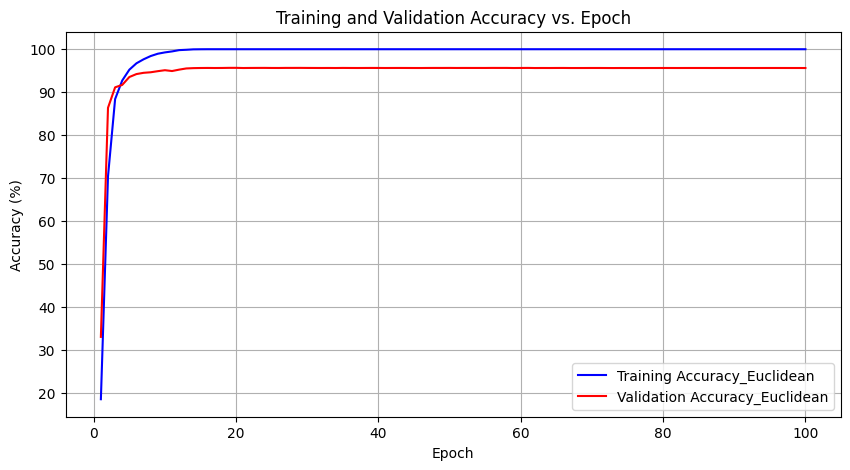

In [17]:
# Plot training and validation accuracy vs. epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, 101), train_accuracy_values, label='Training Accuracy_Euclidean', color='blue')
plt.plot(range(1, 101), val_accuracy_values, label='Validation Accuracy_Euclidean', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

### Hyperbolic training loop

Next step is to train the hyperbolic neural network.

In addition to the optimizers, there is one more difference between Euclidean and hyperbolic training loops; `Exponential Map`. As the hyperbolic Net expects hyperbolic input, data is projected to the hyperbolic space using `manifold.expmap0(flat_inputs)`.


In [18]:
# Define lists to store loss and accuracy values
manifold = geoopt.PoincareBall()
epoch_loss_values_hyp = []
train_accuracy_values_hyp = []
val_accuracy_values_hyp = []

# Training loop for 100 epochs
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0

    # Iterate over the training data
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        hyperbolic_optimizer.zero_grad()

        # forward + backward + optimize
        # ------------------------------
        # Hyperbolic inputs
        flat_inputs = torch.flatten(inputs, start_dim=1)
        hyp_inputs = manifold.expmap0(flat_inputs)
        # ------------------------------
        outputs = hyperbolic_net(hyp_inputs, manifold)
        loss = criterion(outputs, labels)
        loss.backward()
        hyperbolic_optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Record the average loss for the epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_loss_values.append(epoch_loss)

    # Print the average loss and validation accuracy every 5 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/100], Loss: {epoch_loss:.3f}')

        # Calculate training accuracy
        correct = 0
        total = 0
        for data in trainloader:
            train_images, train_labels = data

            train_images = train_images.to(device)
            train_labels = train_labels.to(device)

            # calculate outputs by running images through the network
            flatten_train_images = torch.flatten(train_images, start_dim=1)
            hyp_flatten_train_images = manifold.expmap0(flatten_train_images)
            train_outputs = hyperbolic_net(hyp_flatten_train_images, manifold)
            # the class with the highest energy is what we choose as prediction
            _, train_predicted = torch.max(train_outputs.data, 1)
            total += train_labels.size(0)
            correct += (train_predicted == train_labels).sum().item()
        train_accuracy = 100 * correct / total
        train_accuracy_values_hyp.append(train_accuracy)

        # Calculate validation accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                val_images, val_labels = data

                val_images = val_images.to(device)
                val_labels = val_labels.to(device)

                # calculate outputs by running images through the network
                flatten_val_images = torch.flatten(val_images, start_dim=1)
                hyp_flatten_val_images = manifold.expmap0(flatten_val_images)
                val_outputs = hyperbolic_net(hyp_flatten_val_images, manifold)
                # the class with the highest energy is what we choose as prediction
                _, val_predicted = torch.max(val_outputs.data, 1)
                total += val_labels.size(0)
                correct += (val_predicted == val_labels).sum().item()
        val_accuracy = 100 * correct / total
        val_accuracy_values_hyp.append(val_accuracy)

        print(f'Accuracy of the network on the validation set: {val_accuracy:.2f} %')


Epoch [10/100], Loss: 1.471
Accuracy of the network on the validation set: 93.66 %
Epoch [20/100], Loss: 1.445
Accuracy of the network on the validation set: 94.56 %
Epoch [30/100], Loss: 1.439
Accuracy of the network on the validation set: 94.67 %
Epoch [40/100], Loss: 1.437
Accuracy of the network on the validation set: 94.71 %
Epoch [50/100], Loss: 1.436
Accuracy of the network on the validation set: 94.84 %
Epoch [60/100], Loss: 1.435
Accuracy of the network on the validation set: 94.88 %
Epoch [70/100], Loss: 1.434
Accuracy of the network on the validation set: 94.87 %
Epoch [80/100], Loss: 1.433
Accuracy of the network on the validation set: 94.87 %
Epoch [90/100], Loss: 1.433
Accuracy of the network on the validation set: 94.86 %
Epoch [100/100], Loss: 1.433
Accuracy of the network on the validation set: 94.88 %


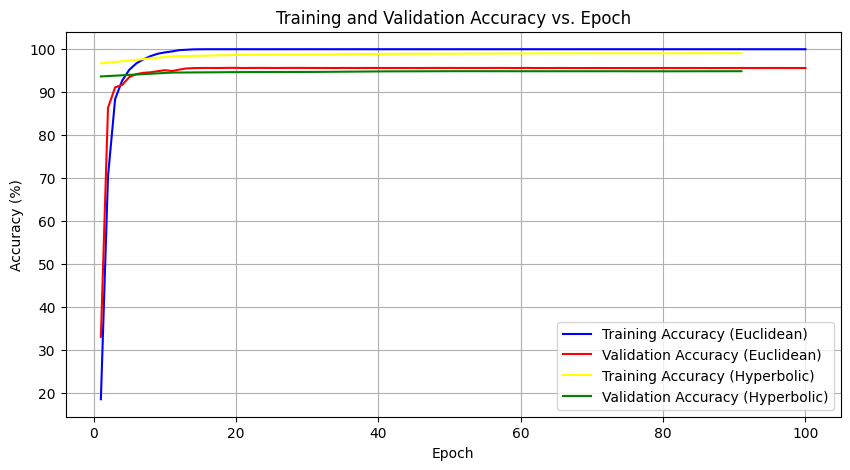

In [19]:
plt.figure(figsize=(10, 5))

# Plot training accuracy for Euclidean model
plt.plot(range(1, 101), train_accuracy_values, label='Training Accuracy (Euclidean)', color='blue')

# Plot validation accuracy for Euclidean model
plt.plot(range(1, 101), val_accuracy_values, label='Validation Accuracy (Euclidean)', color='red')

# Plot training accuracy for Hyperbolic model
plt.plot(range(1, 101,10), train_accuracy_values_hyp, label='Training Accuracy (Hyperbolic)', color='yellow')

# Plot validation accuracy for Hyperbolic model
plt.plot(range(1, 101,10), val_accuracy_values_hyp, label='Validation Accuracy (Hyperbolic)', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()
plt.grid(True)


plt.show()


### Testing function
Once the training loop is complete, it's time to see how the trained Euclidean and hyperbolic models work given the testing split.

First, we visualize a batch of test images and the predicted labels given the batch.

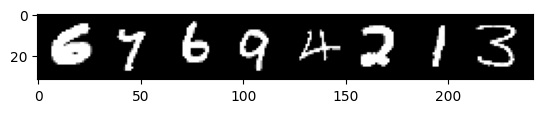

GroundTruth: 6   7   6   9   4   2   1   3  
Euclidean:   6   7   6   9   4   2   1   3  
Hyperbolic:  6   7   6   9   4   2   1   3  


In [20]:
dataiter = iter(testloader)
images, labels = next(dataiter)  # Use next() to get the next batch

flatten_images = torch.flatten(images, start_dim=1).to(device)
# ======================================
outputs = euclidean_net(flatten_images)
_, euclidean_predicted = torch.max(outputs, 1)
# ======================================
hyp_inputs = manifold.expmap0(flatten_images)
outputs = hyperbolic_net(hyp_inputs, manifold)
_, hyperbolic_predicted = torch.max(outputs, 1)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:', ' '.join(f'{classes_num[labels[j]]:3s}' for j in range(8)))
print('Euclidean:  ', ' '.join(f'{classes_num[euclidean_predicted[j]]:3s}' for j in range(8)))
print('Hyperbolic: ', ' '.join(f'{classes_num[hyperbolic_predicted[j]]:3s}' for j in range(8)))



In [21]:
# Test dataset - downloading and loading the testing dataset.
testset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, download=True, transform=transform)
testset_small, _ = torch.utils.data.random_split(main_trainset, [30000, 30000], generator=torch.Generator().manual_seed(42))

# Create dataloaders for the train, val and test sets
batch_size = 8
testloader = torch.utils.data.DataLoader(testset_small, batch_size=batch_size, shuffle=False, num_workers=2)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

euclidean_correct = 0
hyperbolic_correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        flatten_images = torch.flatten(images, start_dim=1)

        euclidean_outputs = euclidean_net(flatten_images)
        # ======================================
        hyp_inputs = manifold.expmap0(flatten_images)
        hyperbolic_outputs = hyperbolic_net(hyp_inputs, manifold)

        # the class with the highest energy is what we choose as prediction
        _, euclidean_predicted = torch.max(euclidean_outputs.data, 1)
        _, hyperbolic_predicted = torch.max(hyperbolic_outputs.data, 1)
        total += labels.size(0)

        euclidean_correct += (euclidean_predicted == labels).sum().item()
        hyperbolic_correct += (hyperbolic_predicted == labels).sum().item()

print(f'Accuracy of the Euclidean network on the 10000 test images: {100 * euclidean_correct // total} %')
print(f'Accuracy of the Hyperbolic network on the 10000 test images: {100 * hyperbolic_correct // total} %')

Accuracy of the Euclidean network on the 10000 test images: 97 %
Accuracy of the Hyperbolic network on the 10000 test images: 96 %


embeddings prototype

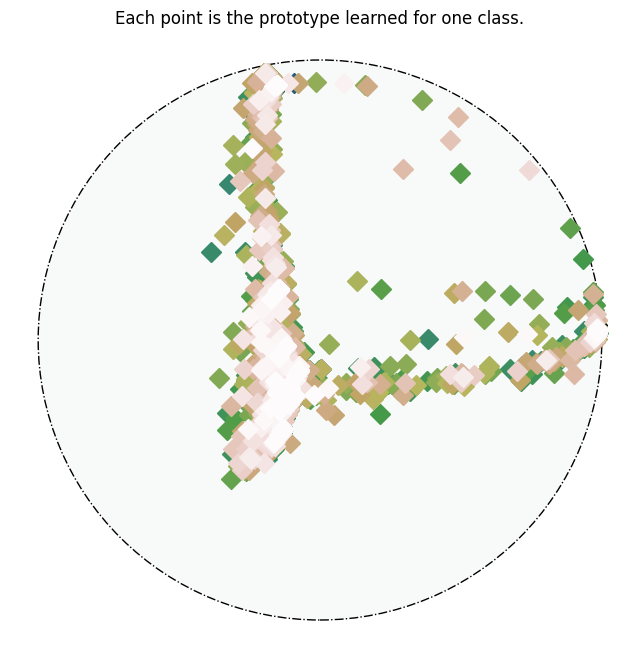

In [25]:

from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_prototypes(prototypes):
    num_classes, dims = prototypes.shape

    # Check if dims == 2
    if dims != 2:
        print("Error: Plotting is supported only for 2-dimensional prototypes.")
        return

    cmap = plt.get_cmap('gist_earth')
    colors_list = [cmap(i) for i in np.linspace(0, 1, num_classes + 4)]

    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    for i in range(num_classes):
        plt.plot(prototypes[i, 0], prototypes[i, 1], markersize=10, marker='D', linestyle='none', color=colors_list[i])

    ball = geoopt.PoincareBall()
    ax.add_patch(plt.Circle((0, 0), 1, fill=True, ec='black', fc='#f8f9f9', linestyle='-.', linewidth=1, zorder=0))

    ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['left'].set_color('white')

    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, labelbottom=False)

    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.title('Each point is the prototype learned for one class.')
    plt.show()

def extract_embeddings(loader, model, manifold):
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in loader:
            images, labels_batch = data
            images = images.to(device)
            labels_batch = labels_batch.to(device)
            # Get embeddings from the model
            hyp_inputs = manifold.expmap0(images.view(images.size(0), -1))
            outputs = model(hyp_inputs, manifold)
            embeddings.append(outputs.detach().cpu().numpy())
            labels.append(labels_batch.detach().cpu().numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

# Extract embeddings and corresponding labels from the test loader
embeddings, true_labels = extract_embeddings(testloader, hyperbolic_net, manifold)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Convert embeddings_pca to PyTorch tensor
embeddings_pca_tensor = torch.tensor(embeddings_pca, dtype=torch.float32, device=device)

# Project embeddings onto the Poincaré ball
ball = geoopt.PoincareBall()
embedded_points = ball.projx(embeddings_pca_tensor)

# Plot the prototypes on the Poincaré ball
plot_prototypes(embedded_points.cpu().numpy())

